### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第51~53天作業(期中考)
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/04/27
### 改版日期:  
### 改版備註: 參考網址
### https://medium.com/@williamkoehrsen/machine-learning-with-python-on-the-enron-dataset-8d71015be26d
### 2020/04/29 增加梯度提升機及隨機森林
### 2020/04/30 增加資料清洗與評估結果顯示
### 2020/05/04 增加資料清洗
### 2020/05/07 增加特徵重要性顯示
### 2020/05/08 調整離峰值處理
### 2020/05/09 調整超參數

請至以下Kaggle競賽平台期中考連結參加考試，請按join competition加入測驗 

並將任一次提交完成畫面截圖，上傳到github並回到官網完成提交。(提交畫面截圖範例)

https://www.kaggle.com/t/4e455552ac9b4a088ccae16e27d22be8

### ANS:

## 目錄
* <a href="#sec1">1. 簡介</a>
  * <a href="#sec1.1"> 1.1. 匯入所需套件 </a>

* <a href="#sec2">2. 資料清洗</a>
  * <a href="#sec2.1"> 2.1. 匯入資料集 </a>
  * <a href="#sec2.2"> 2.2. 分析資料型態與分布 </a>
  * <a href="#sec2.3"> 2.3. 資料填補分析 </a>
  * <a href="#sec2.4"> 2.4. 缺失值填補 </a>
  * <a href="#sec2.5"> 2.5. 離峰值處理 </a>
  * <a href="#sec2.6"> 2.6. 異常值處理 </a>
  * <a href="#sec2.7"> 2.7. 資料檢查 </a>

* <a href="#sec3">3. 特徵工程</a>
  
* <a href="#sec4">4. 套用模型</a>
  * <a href="#sec4.1"> 4.1. 羅吉斯迴歸 </a>
  * <a href="#sec4.2"> 4.2. 梯度提升機 </a>
  * <a href="#sec4.3"> 4.3. 隨機森林 </a>
  * <a href="#sec4.4"> 4.4. 堆疊泛化 ( Stacking)</a>
  * <a href="#sec4.5"> 4.5. AdaBoostClassifier</a>
  * <a href="#sec4.6"> 4.6. 決策樹</a>
  * <a href="#sec4.7"> 4.7. 樸素貝里斯</a>
  * <a href="#sec4.8"> 4.8. SVM</a>
* <a href="#sec5">5. 評估結果</a>  

<a id='sec1'></a>
### 1. 簡介
該項目是Udacity Data Analyst Nanodegree的一部分，涉及機器學習入門模塊。其主要範圍是根據因安然（Enron）醜聞而公開的財務和電子郵件數據來構建感興趣的人（POI）標識符，如下所述。
2000年，安然（Enron）是美國最大的公司之一。到2002年，由於廣泛的公司欺詐行為，該公司破產了。在最終的聯邦調查中，大量的通常是機密信息被輸入到公共記錄中，包括成千上萬的電子郵件和高級管理人員的詳細財務數據。

<a id='sec1.1'></a>
#### 1.1. 匯入套件及資料
本節為將在此python筆記本中使用的所有套件匯入

In [51]:
# 做完特徵工程前的所有準備
import os
import pandas as pd
import numpy as np
import copy, time
import pprint
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

<a id='sec2'></a>
### 2. 資料清洗

<a id='sec2.1'></a>
#### 2.1. 匯入資料集

In [52]:
data_path = 'data/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')
index_name = 'name'
df_train = df_train.set_index(df_train[index_name])
df_test = df_test.set_index(df_test[index_name])
print(df_train.shape)
print(df_test.shape)

(113, 22)
(33, 21)


<a id='sec2.2'></a>
#### 2.2. 分析資料型態與分布

In [53]:
# 重組資料成為訓練 / 預測用格式
target_col = 'poi'
key_col = 'name'
df_train[target_col] = df_train[target_col].map(lambda i: 1 if i == True else 0)
train_Y = df_train[target_col]
ids = df_test[key_col]
df_train_nokey = df_train.drop([key_col] , axis=1)
df_test_nokey = df_test.drop([key_col] , axis=1)
df = pd.concat([df_train_nokey,df_test_nokey])

In [54]:
# 秀出資料欄位的類型與數量
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
dtype_df

,Column Type,Count
0,float64,20
1,object,1


In [55]:
#確定只有 int64, float64, object 三種類型後, 分別將欄位名稱存於二個 list(數值及文字) 中
num_features = []
object_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)    
    else:
        object_features.append(feature)
print(f'{len(num_features)} num Features : {num_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

20 num Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'poi', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

1 Object Features : ['email_address']


'column[bonus]s value is from 97343619.0 to 70000.0'


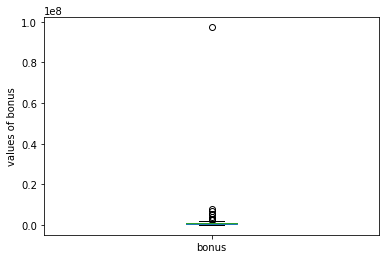

'column[deferral_payments]s value is from 32083396.0 to -102500.0'


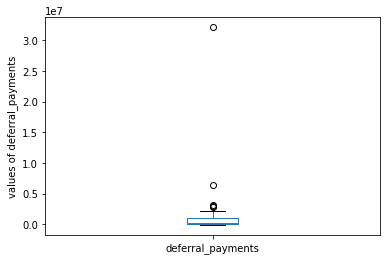

'column[deferred_income]s value is from -833.0 to -27992891.0'


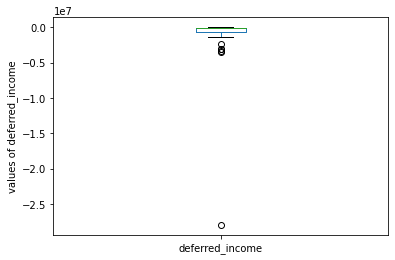

'column[director_fees]s value is from 1398517.0 to 3285.0'


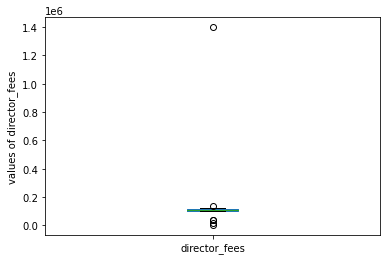

'column[exercised_stock_options]s value is from 311764000.0 to 3285.0'


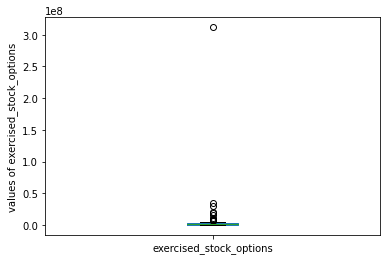

'column[expenses]s value is from 5235198.0 to 148.0'


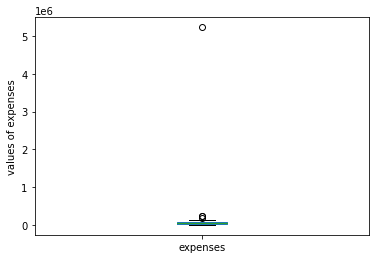

'column[from_messages]s value is from 14368.0 to 12.0'


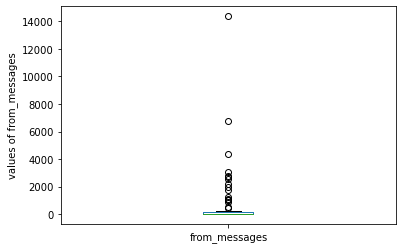

'column[from_poi_to_this_person]s value is from 528.0 to 0.0'


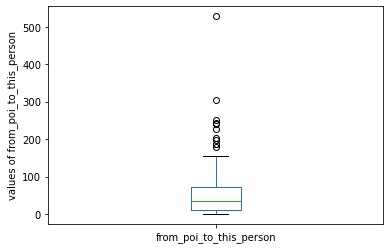

'column[from_this_person_to_poi]s value is from 609.0 to 0.0'


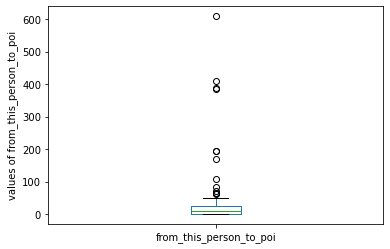

'column[loan_advances]s value is from 83925000.0 to 400000.0'


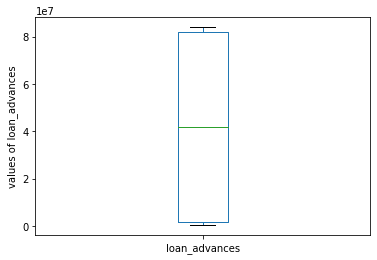

'column[long_term_incentive]s value is from 48521928.0 to 69223.0'


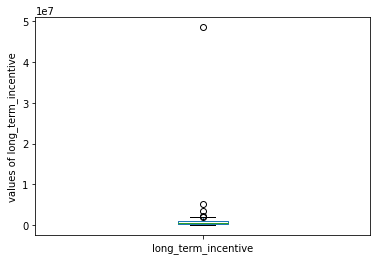

'column[other]s value is from 42667589.0 to 2.0'


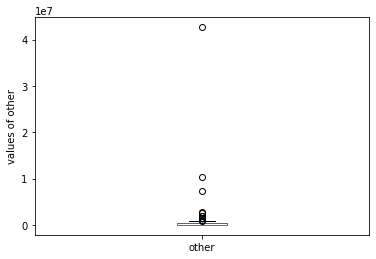

'column[poi]s value is from 1.0 to 0.0'


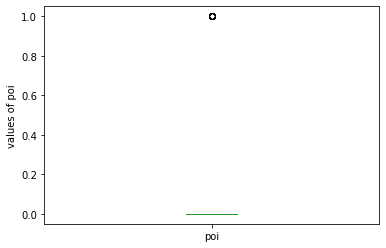

'column[restricted_stock]s value is from 130322299.0 to -2604490.0'


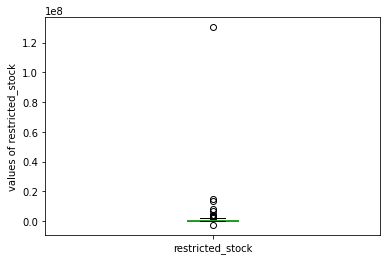

'column[restricted_stock_deferred]s value is from 15456290.0 to -7576788.0'


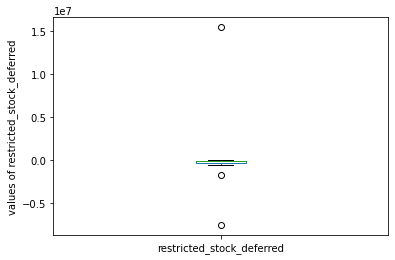

'column[salary]s value is from 26704229.0 to 477.0'


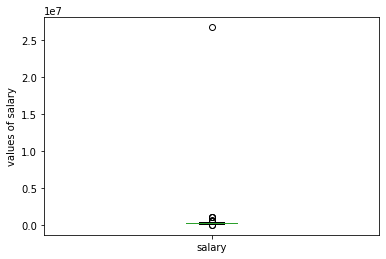

'column[shared_receipt_with_poi]s value is from 5521.0 to 2.0'


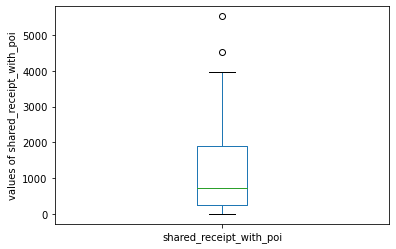

'column[to_messages]s value is from 15149.0 to 57.0'


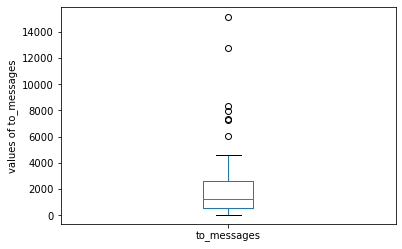

'column[total_payments]s value is from 309886585.0 to 148.0'


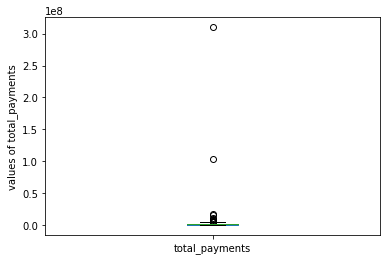

'column[total_stock_value]s value is from 434509511.0 to -44093.0'


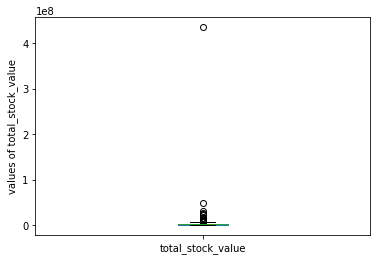

In [56]:
# 繪製廂型圖
import matplotlib.pyplot as plt
%matplotlib inline

# 檢視數值欄位的數值範圍
# 參考網址
# https://www.itread01.com/content/1541665023.html
for col in num_features:    
    pprint.pprint('column[{0}]''s value is from {1} to {2}'.format(col,df[col].max(),df[col].min()))
    
    fig,axes = plt.subplots()
    df[col].plot(kind='box',ax=axes)
    axes.set_ylabel('values of {0}'.format(col))
    plt.show()

In [57]:
def visualize3Feats(dataset, features):
    '''Shows the distribution and the boxplot for the given features of a pandas.Dataframe:
        dataset = pandas dataframe.
        features = list of features of interest'''
    ## Building the Figure:
    fig, axes = plt.subplots(2,3,figsize=(15,6), sharex=False)
    for col, feat in enumerate(features):
        dataset[feat].plot(kind='kde', ax=axes[0,col])        
        sns.boxplot(x=dataset[feat], ax=axes[1,col])
        axes[0,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
        axes[1,col].set_xlim(dataset[feat].min(), dataset[feat].max()*1.1);
    return

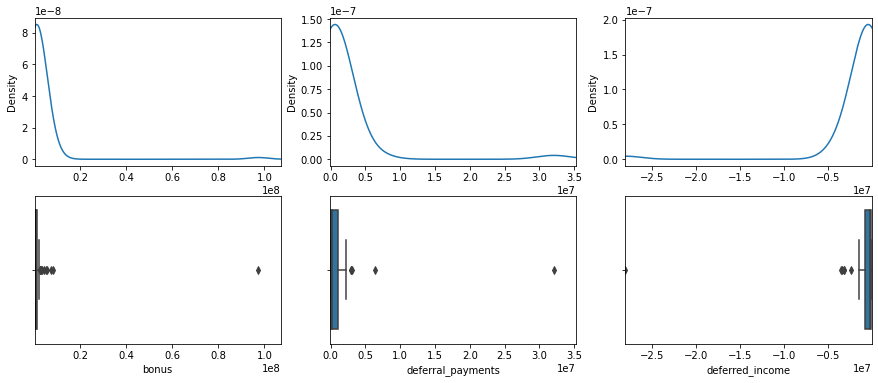

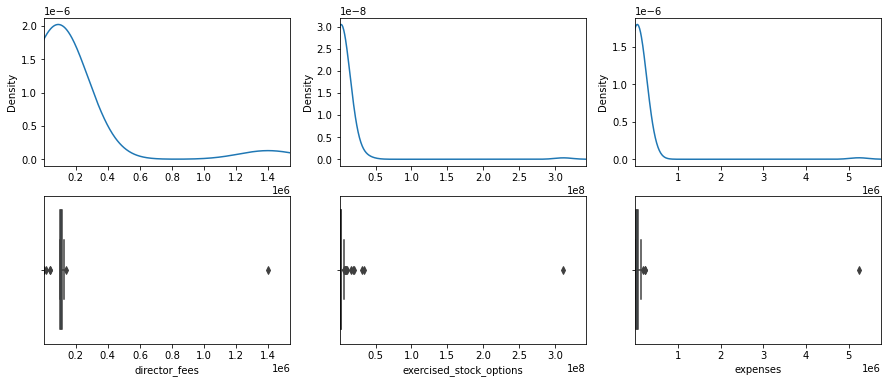

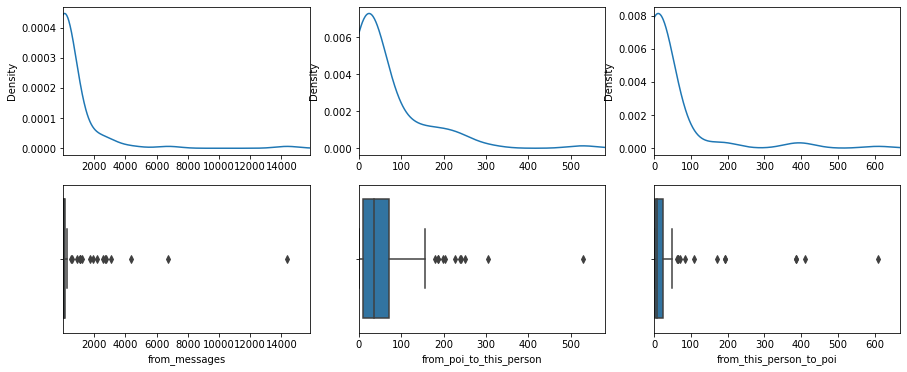

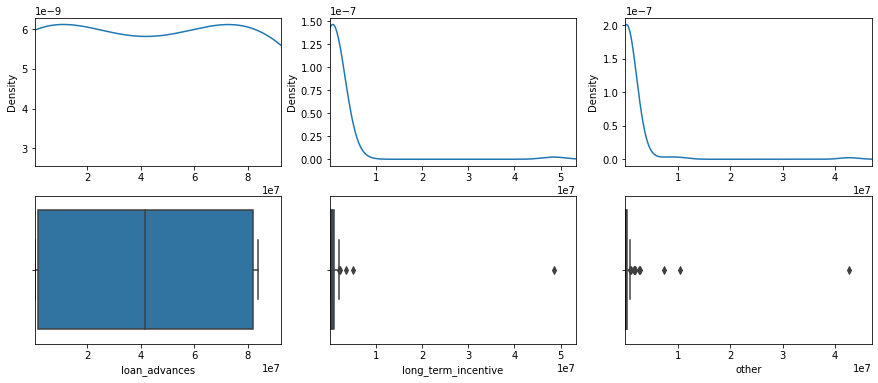

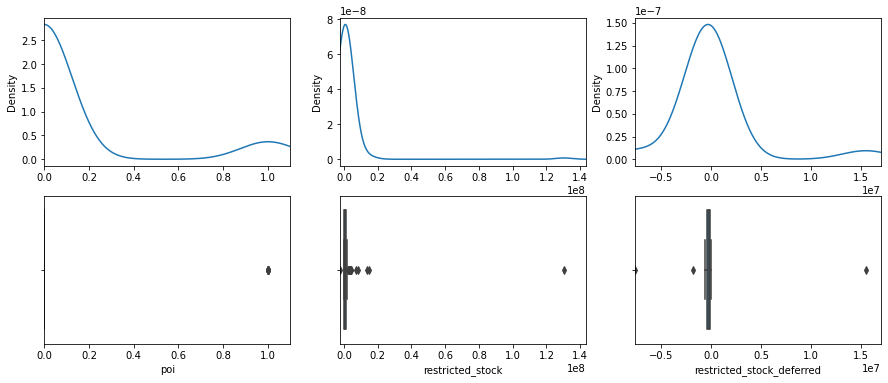

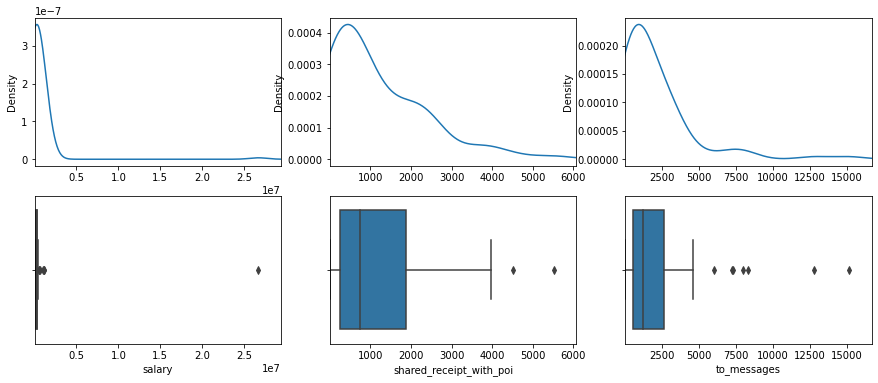

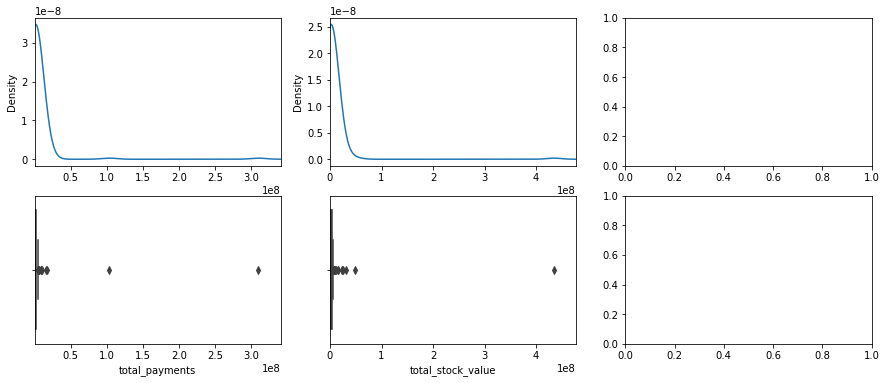

In [58]:
### 繪製KDE圖型及箱型圖:
numPlots = int(np.ceil(len(num_features)/3.))
for i in range(numPlots):
    shift = i*3
    visualize3Feats(df,num_features[0+shift:3+shift])

In [59]:
# 欄位值計算
print(df.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())
print(df['poi'])

email_address    111
dtype: int64
----------------------
poi                            2
loan_advances                  4
director_fees                 17
restricted_stock_deferred     18
deferral_payments             39
from_this_person_to_poi       41
bonus                         41
deferred_income               44
long_term_incentive           52
from_poi_to_this_person       57
from_messages                 64
shared_receipt_with_poi       83
to_messages                   86
other                         92
expenses                      94
salary                        94
restricted_stock              97
exercised_stock_options      101
total_stock_value            124
total_payments               125
dtype: int64
name
RICE KENNETH D          1.0
SKILLING JEFFREY K      1.0
SHELBY REX              1.0
KOPPER MICHAEL J        1.0
CALGER CHRISTOPHER F    1.0
                       ... 
BIBI PHILIPPE A         NaN
SHERRIFF JOHN R         NaN
GIBBS DANA R            NaN
LINDHOLM TOD 

<a id='sec2.3'></a>
#### 2.3. 資料填補分析

In [60]:
# 削減類別欄位, 只剩數值型欄位
df_num_only = df[num_features]
train_num = train_Y.shape[0]
df_num_only.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
name,,,,,,,,,,,,,,,,,,,,
RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,1.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,1.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
SHELBY REX,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,1.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,1.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,1.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [61]:
# 欄位值計算
print(df_num_only.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).sort_values())
print('----------------------')
print(df_num_only.select_dtypes(include=["float64"]).apply(pd.Series.nunique, axis = 0).sort_values())

Series([], dtype: float64)
----------------------
poi                            2
loan_advances                  4
director_fees                 17
restricted_stock_deferred     18
deferral_payments             39
from_this_person_to_poi       41
bonus                         41
deferred_income               44
long_term_incentive           52
from_poi_to_this_person       57
from_messages                 64
shared_receipt_with_poi       83
to_messages                   86
other                         92
expenses                      94
salary                        94
restricted_stock              97
exercised_stock_options      101
total_stock_value            124
total_payments               125
dtype: int64


<a id='sec2.4'></a>
#### 2.4. 缺失值填補

In [62]:
#檢查統計值
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,82.0,2.374235e+06,1.071333e+07,70000.0,431250.00,769375.0,1200000.00,97343619.0
deferral_payments,39.0,1.642674e+06,5.161930e+06,-102500.0,81573.00,227449.0,1002671.50,32083396.0
deferred_income,49.0,-1.140475e+06,4.025406e+06,-27992891.0,-694862.00,-159792.0,-38346.00,-833.0
director_fees,17.0,1.668049e+05,3.198914e+05,3285.0,98784.00,108579.0,113784.00,1398517.0
exercised_stock_options,102.0,5.987054e+06,3.106201e+07,3285.0,527886.25,1310813.5,2547724.00,311764000.0
expenses,95.0,1.087289e+05,5.335348e+05,148.0,22614.00,46950.0,79952.50,5235198.0
from_messages,86.0,6.087907e+02,1.841034e+03,12.0,22.75,41.0,145.50,14368.0
from_poi_to_this_person,86.0,6.489535e+01,8.697924e+01,0.0,10.00,35.0,72.25,528.0
from_this_person_to_poi,86.0,4.123256e+01,1.000731e+02,0.0,1.00,8.0,24.75,609.0
loan_advances,4.0,4.196250e+07,4.708321e+07,400000.0,1600000.00,41762500.0,82125000.00,83925000.0


In [63]:
# 付款資料
payment_data = ['salary','bonus','long_term_incentive','deferred_income','deferral_payments','loan_advances','other'\
               ,'expenses','director_fees','total_payments']
# 股票資產資料
stock_data = ['exercised_stock_options','restricted_stock','restricted_stock_deferred',\
             'total_stock_value']
# 郵件次數資料
email_data=['from_this_person_to_poi','from_poi_to_this_person','to_messages',\
            'shared_receipt_with_poi','to_messages','from_messages']

#驗證資料內容前先複製一份
dt_eval = df.copy()

# 針對付款資料及股票資產資料,用0補齊
dt_eval[payment_data] = dt_eval[payment_data].fillna(0)
dt_eval[stock_data] = dt_eval[stock_data].fillna(0)
# 針對email次數設定,用0補齊
dt_eval[email_data] = dt_eval[email_data].fillna(0)

<a id='sec2.5'></a>
#### 2.5. 離峰值處理

In [64]:
# TOTAL 及 THE TRAVEL AGENCY IN THE PARK 是合計欄(非個人資料)，增加欄位住記
print(dt_eval.shape[0])
print('index[total]:{0}'.format(str(len(dt_eval[dt_eval.index == 'TOTAL']))))
print('index[THE TRAVEL AGENCY IN THE PARK]:{0}'.format(str(len(dt_eval[dt_eval.index\
== 'THE TRAVEL AGENCY IN THE PARK']))))
dt_eval['outlier']= 0
labels = ['TOTAL','THE TRAVEL AGENCY IN THE PARK']
for indexs in labels:
    if indexs in dt_eval.index:
        dt_eval.loc[indexs,'outlier'] = 1
print(dt_eval['outlier'].value_counts())

146
index[total]:1
index[THE TRAVEL AGENCY IN THE PARK]:1
0    144
1      2
Name: outlier, dtype: int64


<a id='sec2.6'></a>
#### 2.6. 異常值處理

In [65]:
# 計算付款資料合理性
errors = (dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']])
print(errors.shape)
dt_eval[payment_data] = dt_eval[payment_data].fillna(0)
errors = (dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']])
# 補零後，還是有兩筆資料有問題
print(errors.shape)
errors

(2, 22)
(2, 22)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,outlier
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0,0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,137864.0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0,0


In [66]:
# 計算股票資產資料合理性
errors = (dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']])
print(errors.shape)
dt_eval[stock_data] = dt_eval[stock_data].fillna(0)
errors = (dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']])
# 補零後，還是有兩筆資料有問題
print(errors.shape)
errors

(2, 22)
(2, 22)


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,outlier
name,,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,44093.0,0.0,0.0,0.0,102500.0,-44093.0,0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,137864.0,NaN,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0,0


In [67]:
# 查看有問題的兩筆資料，發現資料位移
#驗證資料內容前先複製一份

# Check for any more errors with the payment data
print(len(dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']]))
# Check for any errors with the stock data
print(len(dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']]))

# 'BELFER ROBERT' 資料發現左移,向右SHIFT
key_name = 'BELFER ROBERT'
payment_len = dt_eval[payment_data[:-1]].shape[1]
stock_len = dt_eval[stock_data[:-1]].shape[1]

for i in range(payment_len):
    dt_eval.loc[key_name,payment_data[i]] = dt_eval.loc[key_name,payment_data[i+1]]
dt_eval.loc[key_name,payment_data[payment_len]] = dt_eval.loc[key_name,stock_data[0]]

for i in range(stock_len):
    dt_eval.loc[key_name,stock_data[i]] = float(dt_eval.loc[key_name,stock_data[i+1]])
dt_eval.loc[key_name,stock_data[stock_len]] = 0


# 'BELFER ROBERT' 資料發現右移,向左SHIFT
key_name = 'BHATNAGAR SANJAY'

for i in np.arange(1,stock_len+1)[::-1]:
    dt_eval.loc[key_name,stock_data[i]] = float(dt_eval.loc[key_name,stock_data[i-1]])
dt_eval.loc[key_name,stock_data[0]] = dt_eval.loc[key_name,payment_data[payment_len]]

for i in np.arange(1,payment_len+1)[::-1]:
    dt_eval.loc[key_name,payment_data[i]] = dt_eval.loc[key_name,payment_data[i-1]]
dt_eval.loc[key_name,payment_data[0]] = 0

# Check for any more errors with the payment data
print(len(dt_eval[dt_eval[payment_data[:-1]].sum(axis='columns') !=dt_eval['total_payments']]))
# Check for any errors with the stock data
print(len(dt_eval[dt_eval[stock_data[:-1]].sum(axis='columns') !=dt_eval['total_stock_value']]))

2
2
0
0


In [68]:
# 檢查次數項目是否為正整數(大於等於0)
for col_name in email_data:    
    if all(dt_eval[col_name].dropna().unique()>=0):
        print('column [{0}] pass!'.format(col_name))        
    else:
        print('column [{0}] fail!'.format(col_name))
        print(dt_eval[col_name].dropna().unique())

column [from_this_person_to_poi] pass!
column [from_poi_to_this_person] pass!
column [to_messages] pass!
column [shared_receipt_with_poi] pass!
column [to_messages] pass!
column [from_messages] pass!


In [69]:
IQR = dt_eval.quantile(q=0.75) - dt_eval.quantile(q=0.25)
first_quartile = dt_eval.quantile(q=0.25)
third_quartile = dt_eval.quantile(q=0.75)
outliers = dt_eval[(dt_eval>(third_quartile + 1.5*IQR) ) | (dt_eval<(first_quartile
- 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

name
TOTAL                 15
LAY KENNETH L         15
FREVERT MARK A        12
BELDEN TIMOTHY N       9
BAXTER JOHN C          8
LAVORATO JOHN J        8
WHALLEY LAWRENCE G     8
HAEDICKE MARK E        8
SKILLING JEFFREY K     8
BUY RICHARD B          7
KEAN STEVEN J          7
KITCHEN LOUISE         6
dtype: int64

In [70]:
# dt_eval['poi'].value_counts()
# # Remove the outlier individuals
# dt_eval.drop(axis=0, labels=['LAY KENNETH L', 'FREVERT MARK A',
# 'BELDEN TIMOTHY N', 'BAXTER JOHN C'], inplace=True)
# # Find the number of poi and non poi now in the data
# dt_eval['poi'].value_counts()

<a id='sec2.7'></a>
#### 2.7. 資料檢查

In [71]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)

In [72]:
#顯示訓練集其中資料遺失比例(只剩poi跟email_address)
na_check(dt_eval)

,Missing Ratio
email_address,23.972603
poi,22.602740


<a id='sec3'></a>
### 3. 特徵工程

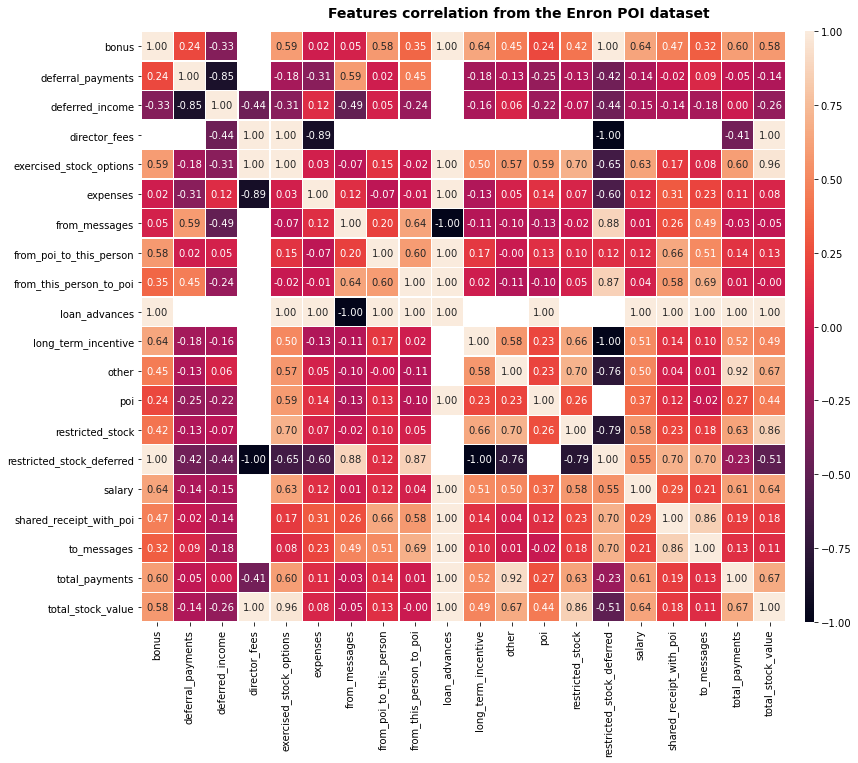

In [73]:
#繪製熱點圖
## Calculating the correlation among features by Pearson method
correlationDataframe = df_train[num_features].corr()

# Drawing a heatmap with the numeric values in each cell
fig1, ax = plt.subplots(figsize=(14,10))
fig1.subplots_adjust(top=.945)
plt.suptitle('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold')

cbar_kws = {'orientation':"vertical", 'pad':0.025, 'aspect':70}
sns.heatmap(correlationDataframe, annot=True, fmt='.2f', linewidths=.3, ax=ax, cbar_kws=cbar_kws);

In [74]:
### 建立新特徵 
dt_eval["fraction_from_poi"] = dt_eval["from_poi_to_this_person"].\
                                  divide(dt_eval["to_messages"], fill_value=0.0) 

dt_eval["fraction_to_poi"] = dt_eval["from_this_person_to_poi"].\
                                divide(dt_eval["from_messages"], fill_value=0.0)
dt_eval['shared_receipt_poi_ratio'] = dt_eval['shared_receipt_with_poi'].\
                                 divide(dt_eval['to_messages'], fill_value=0.0)

dt_eval['bonus_to_salary'] = dt_eval['bonus'].divide(dt_eval['salary'], fill_value=0.0)
dt_eval['bonus_to_total'] = dt_eval['bonus'].divide(dt_eval['total_payments'], fill_value=0.0)

dt_eval["fraction_from_poi"] = dt_eval["fraction_from_poi"].fillna(0.0)
dt_eval["fraction_to_poi"] = dt_eval["fraction_to_poi"].fillna(0.0)
dt_eval["shared_receipt_poi_ratio"] = dt_eval["shared_receipt_poi_ratio"].fillna(0.0)
dt_eval["bonus_to_salary"] = dt_eval["bonus_to_salary"].fillna(0.0)
dt_eval["bonus_to_total"] = dt_eval["bonus_to_total"].fillna(0.0)

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# 特徵欄位清單(數值欄位+新特徵)
new_features = ['fraction_from_poi','fraction_to_poi','shared_receipt_poi_ratio','bonus_to_salary','bonus_to_total']
feature_list = np.append(num_features,new_features)
# feature_list = num_features
target_col = 'poi'
key_col = 'name'

# 切分訓練集與測試集

df_train_pre = dt_eval[pd.isna(dt_eval[target_col])==False].copy()
train_Y = df_train_pre[target_col]
df_train_pre = df_train_pre[feature_list]
df_train_pre = df_train_pre.drop([target_col] , axis=1)
feature_column = np.array(df_train_pre.columns)

df_test_pre = dt_eval[pd.isna(dt_eval[target_col])==True].copy()
df_test_pre = df_test_pre[feature_list]
df_test_pre = df_test_pre.drop([target_col] , axis=1)
ids = df_test[key_col]


# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range = (0, 1))

# 縮放器載入, 對 train, test 進行縮放轉換
df_train_pre = scaler.fit_transform(df_train_pre)
df_test_pre = scaler.fit_transform(df_test_pre)

# 切分訓練集與測試集
train_X = df_train_pre
test_X = df_test_pre

print('Training data shape: ', train_X.shape)
print('Testing data shape: ', test_X.shape)
print(len(feature_column))

Training data shape:  (113, 24)
Testing data shape:  (33, 24)
24


<a id='sec4'></a>
### 4. 套用模型

In [76]:
df_eval_result = pd.DataFrame(columns=['accuracy_score','f1_score','precision_score','recall_score'])
def show_eval_result(y_test,y_pred , model_name):
    # 分類要驗證正確率(accucry)
    acc = accuracy_score(y_test,y_pred)
    print("accuracy_score: ", acc)
    f1 = f1_score(y_test,y_pred)
    print("f1_score: ", f1)
    # 使用 Precision 評估
    precision = precision_score(y_test,y_pred)
    print("precision_score: ", precision)
    # 使用 recall 評估
    recall  = recall_score(y_test,y_pred)
    print("recall_score: ", recall)
    row = pd.Series({'accuracy_score':acc,'f1_score':f1,'precision_score':precision,\
                     'recall_score':recall},name=model_name)
    return row

In [77]:
def show_feature_import(column_names, importances):
    #將特徵權重排序之後寫入dict
    feature_importances_ = {}
    _feat_labels = column_names
    _importances = importances

    # 取得特徵權重排序的索引值
    indices = np.argsort(_importances)[::-1]

    for f in range(len(_importances)):
        feature_importances_.update({_feat_labels[indices[f]]: _importances[indices[f]]})

    #  確認特徵權重
    return feature_importances_

In [78]:
def save_result_file(ids,test_X,clf,clf_type):
    '''儲存預測結果'''
    output_path = 'output/'
    prediction = clf.predict_proba(test_X)[:, 1]
    submit = pd.DataFrame({'name': ids, 'poi': prediction})
    f_app_result = os.path.join(output_path, 'Day_051_To_053_{0}.csv'.format(clf_type))
    submit.to_csv(f_app_result,index=False)

In [79]:
# 切分訓練集與測試集
x_train,x_test,y_train,y_test = train_test_split(train_X,train_Y,test_size=0.25,random_state=4)

<a id='sec4.1'></a>
#### 4.1. 羅吉斯迴歸

##### 驗證訓練集
[Pandas: Appending a row to a dataframe and specify its index label](https://stackoverflow.com/questions/16824607/pandas-appending-a-row-to-a-dataframe-and-specify-its-index-label "Pandas: Appending a row to a dataframe and specify its index label")

In [80]:
# 使用羅吉斯迴歸
clf_lr =  LogisticRegression(C = 0.0001)

# 進行訓練
clf_lr.fit(x_train,y_train)

# 預測測試集
y_pred = clf_lr.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'lr'))

accuracy_score:  0.8620689655172413
f1_score:  0.0
precision_score:  0.0
recall_score:  0.0


In [81]:
# 設定模型與模型參數
# grid_values = {'penalty': ['l1','l2'], 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]}
# lr = GridSearchCV(LogisticRegression(), param_grid=grid_values,cv=5)
clf_lr =  LogisticRegression(C = 0.0001)
clf_lr.fit(train_X, train_Y)
# lr.best_estimator_

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
# 儲存預測結果(羅吉斯迴歸)
save_result_file(ids,test_X,clf_lr,'lr')

<a id='sec4.2'></a>
#### 4.2. 梯度提升機

##### 驗證訓練集

In [83]:
# 使用梯度提升機
clf_gdbt =  GradientBoostingClassifier()

# 進行訓練
clf_gdbt.fit(x_train,y_train)

# 預測測試集
y_pred = clf_gdbt.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'gdbt'))
show_feature_import(feature_column,clf_gdbt.feature_importances_)

accuracy_score:  0.8620689655172413
f1_score:  0.5
precision_score:  0.5
recall_score:  0.5


{'exercised_stock_options': 0.2517307719024607,
 'shared_receipt_poi_ratio': 0.18391349974143564,
 'fraction_to_poi': 0.11259513897051304,
 'bonus_to_salary': 0.09320718033295039,
 'bonus_to_total': 0.08041123205460915,
 'fraction_from_poi': 0.061086857650443104,
 'expenses': 0.059278233533973566,
 'bonus': 0.042790264702271236,
 'to_messages': 0.023571504534541633,
 'restricted_stock': 0.018931944446383988,
 'total_payments': 0.01726970204158501,
 'shared_receipt_with_poi': 0.01586973543619301,
 'long_term_incentive': 0.010547528951221397,
 'other': 0.009314678541881597,
 'total_stock_value': 0.007147233428441403,
 'from_messages': 0.006552533666411713,
 'deferred_income': 0.004956871912825542,
 'salary': 0.0006849470333965457,
 'from_poi_to_this_person': 0.00013994811238111224,
 'from_this_person_to_poi': 1.9300608018907078e-07,
 'restricted_stock_deferred': 0.0,
 'loan_advances': 0.0,
 'director_fees': 0.0,
 'deferral_payments': 0.0}

In [84]:
# 設定模型與模型參數
clf_gdbt =  GradientBoostingClassifier()
clf_gdbt.fit(train_X, train_Y)
show_feature_import(feature_column,clf_gdbt.feature_importances_)

{'exercised_stock_options': 0.3148067693981249,
 'shared_receipt_poi_ratio': 0.16406493637584857,
 'bonus': 0.09834067589463143,
 'expenses': 0.06723828986002096,
 'other': 0.06566620709892523,
 'fraction_to_poi': 0.05473094392646487,
 'shared_receipt_with_poi': 0.04300859051296993,
 'long_term_incentive': 0.03172533278695651,
 'deferred_income': 0.025424587136287955,
 'total_stock_value': 0.024201481775781294,
 'bonus_to_salary': 0.02336076395797858,
 'fraction_from_poi': 0.018947734180337936,
 'restricted_stock': 0.017394836702379124,
 'salary': 0.015411681672302873,
 'from_poi_to_this_person': 0.009868970427394484,
 'loan_advances': 0.008953512986720223,
 'total_payments': 0.008473955599557853,
 'bonus_to_total': 0.004141027581869056,
 'to_messages': 0.0037619777658089893,
 'from_messages': 0.0002959254634188625,
 'from_this_person_to_poi': 0.00016474513585747238,
 'deferral_payments': 1.7053760362862785e-05,
 'restricted_stock_deferred': 0.0,
 'director_fees': 0.0}

In [85]:
# 儲存預測結果(梯度提升機預測檔 )
save_result_file(ids,test_X,clf_gdbt,'gdbt')

<a id='sec4.3'></a>
#### 4.3. 隨機森林

##### 驗證訓練集

In [86]:
# 使用隨機森林

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

# rfc =  RandomForestClassifier(random_state = 42)

# clf_rf = GridSearchCV(estimator=rfc, param_grid=param_grid)

clf_rf  =  RandomForestClassifier()
# 進行訓練
clf_rf.fit(x_train,y_train)

# 預測測試集
y_pred = clf_rf.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'rf'))
show_feature_import(feature_column,clf_rf.feature_importances_)

accuracy_score:  0.8620689655172413
f1_score:  0.0
precision_score:  0.0
recall_score:  0.0


{'shared_receipt_poi_ratio': 0.1115432380869915,
 'fraction_to_poi': 0.10947727627041898,
 'exercised_stock_options': 0.10359450023338514,
 'salary': 0.07893209265788613,
 'bonus_to_salary': 0.07794883478294133,
 'restricted_stock': 0.07542274661161341,
 'bonus': 0.054207952867436245,
 'expenses': 0.05342731600349971,
 'total_stock_value': 0.046557716747086725,
 'other': 0.04646464770034304,
 'total_payments': 0.03959022486980161,
 'fraction_from_poi': 0.037587601993799416,
 'bonus_to_total': 0.032281810281429534,
 'shared_receipt_with_poi': 0.028148334317681472,
 'from_poi_to_this_person': 0.025409996954555036,
 'long_term_incentive': 0.024241299304858868,
 'deferred_income': 0.013789200508351175,
 'from_this_person_to_poi': 0.01000001281907522,
 'from_messages': 0.00969139407464414,
 'to_messages': 0.008199586402221036,
 'loan_advances': 0.00799544460720859,
 'deferral_payments': 0.0050316290476288775,
 'restricted_stock_deferred': 0.0004571428571428572,
 'director_fees': 0.0}

In [87]:
# 設定模型與模型參數
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

# rfc =  RandomForestClassifier(random_state = 42)

clf_rf  =  RandomForestClassifier()
clf_rf.fit(train_X, train_Y)
show_feature_import(feature_column,clf_rf.feature_importances_)

{'exercised_stock_options': 0.10730852796443599,
 'other': 0.08229221848430854,
 'total_stock_value': 0.07853259147950536,
 'fraction_to_poi': 0.0769133382831419,
 'shared_receipt_poi_ratio': 0.07358749066909473,
 'expenses': 0.06938868735384339,
 'salary': 0.06254057583233623,
 'bonus': 0.0600374043580386,
 'bonus_to_salary': 0.04552906815004042,
 'restricted_stock': 0.04381239627431523,
 'fraction_from_poi': 0.042322220021589835,
 'total_payments': 0.03486111958774965,
 'bonus_to_total': 0.03389995389180867,
 'from_poi_to_this_person': 0.03305521476064592,
 'from_this_person_to_poi': 0.029676670892761693,
 'deferred_income': 0.026378889286805093,
 'shared_receipt_with_poi': 0.025228668984117936,
 'from_messages': 0.0212977290944733,
 'long_term_incentive': 0.02082350105487417,
 'to_messages': 0.020301999901735895,
 'deferral_payments': 0.007307055593926475,
 'loan_advances': 0.003942378772604612,
 'restricted_stock_deferred': 0.0009424543792793617,
 'director_fees': 1.984492856703733

In [88]:
# 儲存預測結果(隨機森林預測檔 )
save_result_file(ids,test_X,clf_rf,'rf')

<a id='sec4.4'></a>
#### 4.4. 堆疊泛化 ( Stacking)

##### 驗證訓練集

In [89]:
from mlxtend.classifier import StackingClassifier

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林
lr =  LogisticRegression()
gdbt =  GradientBoostingClassifier()
rf =  RandomForestClassifier()
# 進行訓練
lr.fit(x_train,y_train)
gdbt.fit(x_train,y_train)
rf.fit(x_train,y_train)

# stacking
meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)

clf_stacking = StackingClassifier(classifiers = [lr, gdbt, rf], meta_classifier=meta_estimator,\
                              use_probas=True, average_probas=False)

clf_stacking.fit(x_train,y_train)
# 預測測試集
y_pred = clf_stacking.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'stacking'))

accuracy_score:  0.8620689655172413
f1_score:  0.5
precision_score:  0.5
recall_score:  0.5


In [90]:
# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林
lr =  LogisticRegression()
gdbt =  GradientBoostingClassifier()
rf =  RandomForestClassifier()
# 進行訓練
lr.fit(train_X, train_Y)
gdbt.fit(train_X, train_Y)
rf.fit(train_X, train_Y)

# stacking
meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)

clf_stacking = StackingClassifier(classifiers = [lr, gdbt, rf], meta_classifier=meta_estimator,\
                              use_probas=True, average_probas=False)

clf_stacking.fit(train_X, train_Y)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                GradientBoostingClassifier(ccp_alpha=0.0,
                                                           criterion='friedman_...
         

In [91]:
# 儲存預測結果(堆疊泛化 )
save_result_file(ids,test_X,clf_stacking,'stacking')

<a id='sec4.5'></a>
#### 4.5. AdaBoostClassifier

##### 驗證訓練集

In [92]:
# 使用AdaBoostClassifier
# abc =  AdaBoostClassifier(n_estimators=100)

## Defining the Adaboost parameters for GridSearch:
abc_parameters = {"learning_rate" : [0.5, 1., 2., 5., 10., 100.],
                 "n_estimators": [10,50,100,200,500,900,2000],
                 "algorithm": ['SAMME','SAMME.R']}

dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", max_depth = None)
abc = AdaBoostClassifier(base_estimator=dtc)

# run grid search
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)

# 進行訓練
# abc.fit(x_train,y_train)

clf_adaboost.fit(x_train,y_train)

# 預測測試集
y_pred = clf_adaboost.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'abc'))
# show_feature_import(feature_column,clf_adaboost.feature_importances_)

accuracy_score:  0.8620689655172413
f1_score:  0.6
precision_score:  0.5
recall_score:  0.75


In [93]:
# 設定模型與模型參數
# abc =  AdaBoostClassifier(n_estimators=100)
# abc.fit(train_X, train_Y)
# show_feature_import(feature_column,abc.feature_importances_)

## Defining the Adaboost parameters for GridSearch:
abc_parameters = {"learning_rate" : [0.5, 1., 2., 5., 10., 100.],
                 "n_estimators": [10,50,100,200,500,900,2000],
                 "algorithm": ['SAMME','SAMME.R']}

dtc = DecisionTreeClassifier(random_state = 42, max_features = "auto", max_depth = None)
abc = AdaBoostClassifier(base_estimator=dtc)

# run grid search
clf_adaboost = GridSearchCV(abc, param_grid=abc_parameters)

# 進行訓練
# abc.fit(x_train,y_train)

clf_adaboost.fit(train_X, train_Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf

In [94]:
# 儲存預測結果(AdaBoostClassifier)
save_result_file(ids,test_X,clf_adaboost,'abc')

<a id='sec4.6'></a>
#### 4.6. 決策樹

##### 驗證訓練集

In [95]:
# 使用AdaBoostClassifier
clf_dtc =  DecisionTreeClassifier()

# 進行訓練
clf_dtc.fit(x_train,y_train)

# 預測測試集
y_pred = clf_dtc.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'dtc'))
show_feature_import(feature_column,clf_dtc.feature_importances_)

accuracy_score:  0.7586206896551724
f1_score:  0.36363636363636365
precision_score:  0.2857142857142857
recall_score:  0.5


{'exercised_stock_options': 0.31760337552742635,
 'shared_receipt_poi_ratio': 0.22405319012913927,
 'total_stock_value': 0.18666666666666665,
 'fraction_from_poi': 0.11644869750132937,
 'shared_receipt_with_poi': 0.062222222222222213,
 'bonus_to_salary': 0.055672514619882825,
 'expenses': 0.03733333333333331,
 'bonus_to_total': 0.0,
 'from_this_person_to_poi': 0.0,
 'deferral_payments': 0.0,
 'deferred_income': 0.0,
 'director_fees': 0.0,
 'from_messages': 0.0,
 'from_poi_to_this_person': 0.0,
 'other': 0.0,
 'loan_advances': 0.0,
 'long_term_incentive': 0.0,
 'restricted_stock': 0.0,
 'restricted_stock_deferred': 0.0,
 'salary': 0.0,
 'to_messages': 0.0,
 'total_payments': 0.0,
 'fraction_to_poi': 0.0,
 'bonus': 0.0}

In [96]:
# 設定模型與模型參數
clf_dtc =  DecisionTreeClassifier()
clf_dtc.fit(train_X, train_Y)
show_feature_import(feature_column,clf_dtc.feature_importances_)

{'exercised_stock_options': 0.5043759884974837,
 'shared_receipt_poi_ratio': 0.20814492263022358,
 'restricted_stock': 0.08692307692307692,
 'bonus': 0.06952409705559864,
 'other': 0.06583960720130948,
 'total_stock_value': 0.06519230769230769,
 'from_this_person_to_poi': 0.0,
 'deferral_payments': 0.0,
 'deferred_income': 0.0,
 'director_fees': 0.0,
 'fraction_to_poi': 0.0,
 'expenses': 0.0,
 'from_messages': 0.0,
 'from_poi_to_this_person': 0.0,
 'loan_advances': 0.0,
 'total_payments': 0.0,
 'long_term_incentive': 0.0,
 'bonus_to_salary': 0.0,
 'fraction_from_poi': 0.0,
 'restricted_stock_deferred': 0.0,
 'salary': 0.0,
 'shared_receipt_with_poi': 0.0,
 'to_messages': 0.0,
 'bonus_to_total': 0.0}

In [97]:
# 儲存預測結果(決策樹)
save_result_file(ids,test_X,clf_dtc,'dtc')

<a id='sec4.7'></a>
#### 4.7. 樸素貝里斯

##### 驗證訓練集

In [98]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb_parameters = {}
# 使用樸素貝里斯
clf_nb = GridSearchCV(nb, nb_parameters)
clf_nb.fit(x_train,y_train)

# 預測測試集
y_pred = clf_nb.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'nb'))

accuracy_score:  0.6551724137931034
f1_score:  0.4444444444444445
precision_score:  0.2857142857142857
recall_score:  1.0


In [99]:
# 設定模型與模型參數
nb = GaussianNB()
nb_parameters = {}
# 使用樸素貝里斯
clf_nb = GridSearchCV(nb, nb_parameters)
clf_nb.fit(train_X, train_Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [100]:
# 儲存預測結果(樸素貝里斯)
save_result_file(ids,test_X,clf_nb,'nb')

<a id='sec4.8'></a>
#### 4.8. SVM

##### 驗證訓練集

In [101]:
from sklearn import svm

svm_parameters = {'kernel':['linear','rbf','poly','sigmoid'], 
                  'C':[0.5,1.,5.,10.,50.,100.,1000.], 'gamma':['scale']}
svr = svm.SVC()
clf_svc = GridSearchCV(svr, svm_parameters)

clf_svc.fit(x_train,y_train)
# 預測測試集
y_pred = clf_svc.predict(x_test)

# 分類要驗證正確率(accucry)
df_eval_result = df_eval_result.append(show_eval_result(y_test,y_pred,'svm'))

accuracy_score:  0.8620689655172413
f1_score:  0.0
precision_score:  0.0
recall_score:  0.0


In [102]:
# 設定模型與模型參數
svm_parameters = {'kernel':['linear','rbf','poly','sigmoid'], 
                  'C':[0.5,1.,5.,10.,50.,100.,1000.], 'gamma':['scale']}
svr = svm.SVC(probability=True)
clf_svc = GridSearchCV(svr, svm_parameters)
clf_svc.fit(train_X, train_Y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 1000.0],
                         'gamma': ['scale'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [103]:
# 儲存預測結果(SVM)
save_result_file(ids,test_X,clf_svc,'svm')

<a id='sec5'></a>
### 5. 評估結果

In [104]:
# 顯示評估結果
df_eval_result

,accuracy_score,f1_score,precision_score,recall_score
lr,0.862069,0.000000,0.000000,0.00
gdbt,0.862069,0.500000,0.500000,0.50
rf,0.862069,0.000000,0.000000,0.00
stacking,0.862069,0.500000,0.500000,0.50
abc,0.862069,0.600000,0.500000,0.75
dtc,0.758621,0.363636,0.285714,0.50
nb,0.655172,0.444444,0.285714,1.00
svm,0.862069,0.000000,0.000000,0.00
